In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense,LeakyReLU,Conv2D,Reshape,Conv2DTranspose,Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(1)

2 Physical GPUs, 2 Logical GPUs


In [2]:
# ----- DataSet Import ------
(x_train, y_train), (x_test,y_test) = mnist.load_data()

NUM_CLASSES = 10
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
# ----- Feature PreProcessing ----

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32')/ 255.0

# ----- One hot encoding -------
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)

(60000, 28, 28, 1)


In [3]:
def VAEencoder(input_shape=(28,28,1)):
    encoder_input = Input(shape=input_shape,name='encoder_input')
    x = encoder_input
    encoder_layer1 = Conv2D(filters=32,kernel_size=3, strides=1,padding='same')(x)
    activation1 = LeakyReLU()(encoder_layer1)
    encoder_layer2 = Conv2D(filters=64,kernel_size=3, strides=2,padding='same')(activation1)
    activation2 = LeakyReLU()(encoder_layer2)
    encoder_layer3 = Conv2D(filters=64,kernel_size=3, strides=2,padding='same')(activation2)
    activation3 = LeakyReLU()(encoder_layer3)
    encoder_layer4 = Conv2D(filters=64,kernel_size=3, strides=1,padding='same')(activation3)
    activation4 = LeakyReLU()(encoder_layer4)
    before_number = K.int_shape(activation4)[1:]
    flatten = Flatten()(activation4)
    mu = Dense(2, name='mean')(flatten)
    log_var = Dense(2, name='log_var')(flatten)

    def sampling(args):
        mu,log_var = args
        epsilon = K.random_normal(shape=K.shape(mu),mean=0.,stddev=1.)
        sampling = mu + K.exp(log_var/2) * epsilon
        return sampling
    
    encoder_output = Lambda(sampling)([mu,log_var])
    encoder_model = Model(encoder_input,encoder_output)

    return encoder_model,before_number,mu,log_var

In [4]:
def VAEdecoder(k,input_shape=(2,)):
    encoder_output = Input(shape=input_shape)
    dense_1 = Dense(np.prod(k),activation='relu')(encoder_output)
    reshape = Reshape(k)(dense_1)
    decoder_conv2d1 = Conv2DTranspose(64,kernel_size=(3,3),strides=1,padding='same')(reshape)
    activation_d1 = LeakyReLU()(decoder_conv2d1)
    decoder_conv2d2 = Conv2DTranspose(64,kernel_size=(3,3),strides=2,padding='same')(activation_d1)
    activation_d2 = LeakyReLU()(decoder_conv2d2)
    decoder_conv2d3 = Conv2DTranspose(32,kernel_size=(3,3),strides=2,padding='same')(activation_d2)
    activation_d3 = LeakyReLU()(decoder_conv2d3)
    decoder_conv2d4 = Conv2DTranspose(1,kernel_size=(3,3),strides=1,padding='same')(activation_d3)
    activation_d4 = LeakyReLU()(decoder_conv2d4)

    model = Model(encoder_output,activation_d4)
    return model

In [5]:
encoder, k, log_var, mu = VAEencoder()
decoder = VAEdecoder(k)
encoder_in = Input(shape=(28, 28, 1))
x = encoder(encoder_in)
decoder_out = decoder(x)

In [6]:
auto_encoder = Model(encoder_in, decoder_out)

In [7]:
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 2)                 105220    
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         102017    
Total params: 207,237
Trainable params: 207,237
Non-trainable params: 0
_________________________________________________________________


In [8]:
optimizer = Adam(lr=0.0005)
r_loss_factor = 1000
def vae_r_loss(y_true,y_pred):
    r_loss = K.mean(K.square(y_true-y_pred), axis=[1,2,3])
    return r_loss_factor

def vae_kl_loss(y_true,y_pred):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=1)
    return kl_loss

def vae_loss(y_true,y_pred):
    r_loss = vae_r_loss(y_true,y_pred)
    kl_loss = vae_kl_loss(y_true,y_pred)
    return r_loss + kl_loss 

auto_encoder.compile(loss = "MSE",optimizer=optimizer,metrics=['accuracy'])

In [9]:
auto_encoder.fit(x_train,x_train,batch_size=128,epochs=20,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0580 - accuracy: 0.7989 - val_loss: 0.0519 - val_accuracy: 0.7967
Epoch 2/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0502 - accuracy: 0.7985 - val_loss: 0.0478 - val_accuracy: 0.7945
Epoch 3/20
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0470 - accuracy: 0.7982 - val_loss: 0.0457 - val_accuracy: 0.7944
Epoch 4/20
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0454 - accuracy: 0.7984 - val_loss: 0.0444 - val_accuracy: 0.7970
Epoch 5/20
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0444 - accuracy: 0.7987 - val_loss: 0.0443 - val_accuracy: 0.7996
Epoch 6/20
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0437 - accuracy: 0.7989 - val_loss: 0.0432 - val_accuracy: 0.7982
Epoch 7/20
60000/60000 [==============================]

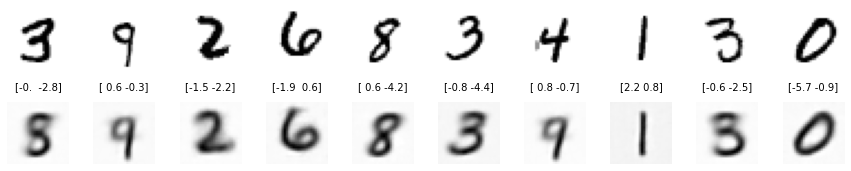

In [11]:
import matplotlib.pyplot as plt
n_to_show = 10
np.random.seed(88)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

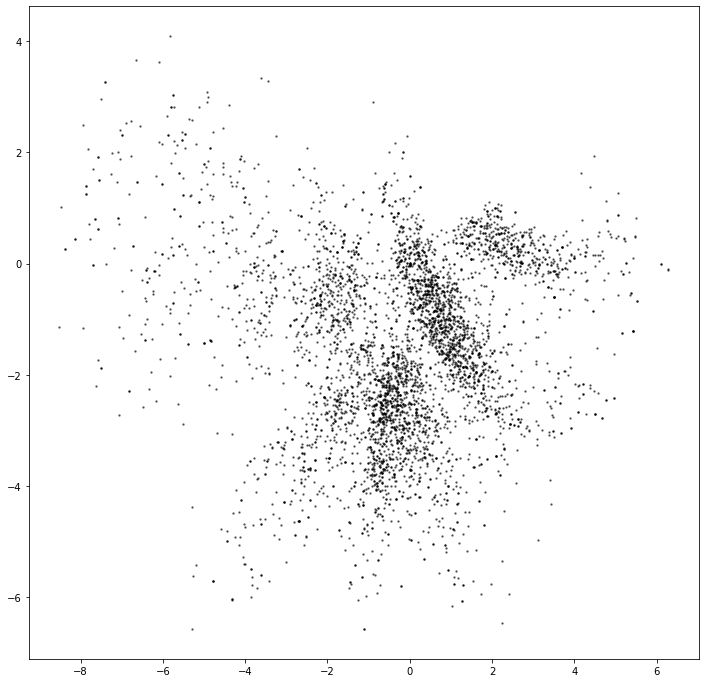

In [12]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

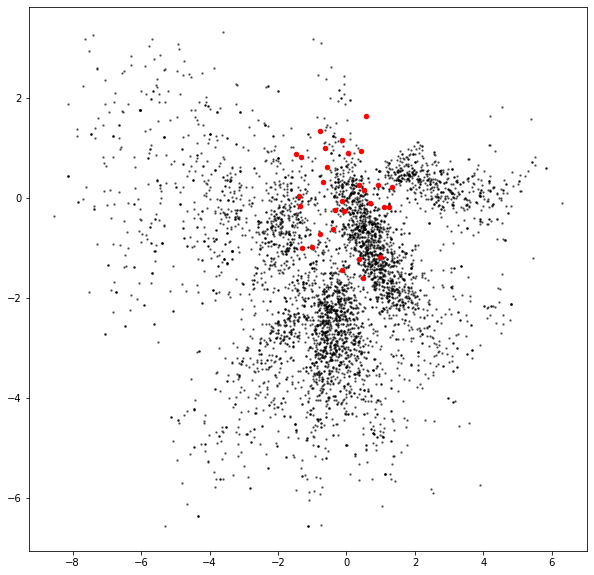

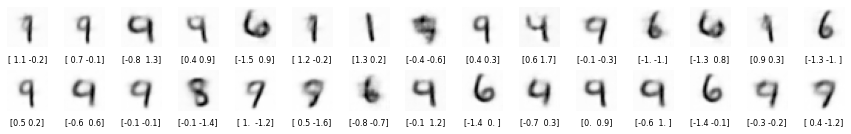

In [15]:
from scipy.stats import norm
figsize = 10
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

In [19]:
from scipy.stats import norm
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c=example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c=example_labels
            , alpha=0.5, s=5)

plt.show()

ValueError: 'c' argument has 50000 elements, which is inconsistent with 'x' and 'y' with size 5000.